# DoWhy 

### What is Causal Inference?
Causal inference is a field of statistics that focuses on identifying and estimating causal relationships between variables. It aims to determine whether a change in one variable (the cause) leads to a change in another variable (the effect). This is crucial for understanding the impact of interventions, policies, or treatments.

Example: When company invested 10,000$ in Advertisement, it resulted in a 20% increase in sales. Here, the investment is the cause, and the increase in sales is the effect.

### Why Do We Need Causal Inference?
Causal inference is essential for making informed decisions based on data. It helps in understanding the effects of actions, policies, or treatments, allowing for better planning and resource allocation. By establishing causal relationships, organizations can optimize their strategies and improve outcomes.

### What is DoWhy?
DoWhy is a open-source Python library for causal inference that provides a unified framework for modeling, estimating, and testing causal effects. It simplifies the process of causal analysis by offering a set of tools and methods to handle various aspects of causal inference, including:
- **Modeling**: Defining causal models using directed acyclic graphs (DAGs).
- **Identification**: Determining whether a causal effect can be identified from the data, based on the causal model.
- **Estimation**: Estimating causal effects using different methods, such as propensity score matching, regression, and instrumental variables.
- **Testing**: Validating causal assumptions and testing the robustness of causal estimates.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dowhy
from dowhy import CausalModel

import warnings
warnings.filterwarnings("ignore")

d:\Pro\CSV AI Workflow\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Simulating a dataset for a causal inference example
# Setting the random seed for reproducibility
np.random.seed(42)

num_users = 10000
num_months = 12

signup_months = np.random.choice(
    np.arange(1, num_months), num_users
) * np.random.randint(
    0, 2, size=num_users
)  # signup_months == 0 means customer did not sign up
df = pd.DataFrame(
    {
        "user_id": np.repeat(np.arange(num_users), num_months),
        "signup_month": np.repeat(
            signup_months, num_months
        ),  # signup month == 0 means customer did not sign up
        "month": np.tile(
            np.arange(1, num_months + 1), num_users
        ),  # months are from 1 to 12
        "spend": np.random.poisson(
            500, num_users * num_months
        ),  # np.random.beta(a=2, b=5, size=num_users * num_months)*1000 # centered at 500
    }
)
# A customer is in the treatment group if and only if they signed up
df["treatment"] = df["signup_month"] > 0
# Simulating an effect of month (monotonically decreasing--customers buy less later in the year)
df["spend"] = df["spend"] - df["month"] * 10
# Simulating a simple treatment effect of 100
after_signup = (df["signup_month"] < df["month"]) & (df["treatment"])
df.loc[after_signup, "spend"] = df[after_signup]["spend"] + 100
df

,user_id,signup_month,month,spend,treatment
0,0,0,1,521,False
1,0,0,2,488,False
2,0,0,3,479,False
3,0,0,4,475,False
4,0,0,5,456,False
...,...,...,...,...,...
119995,9999,2,8,541,True
119996,9999,2,9,499,True
119997,9999,2,10,518,True
119998,9999,2,11,488,True


In [4]:
i = 3

causal_graph = """digraph {
treatment[label="Program Signup in month i"];
pre_spends;
post_spends;
Z->treatment;
pre_spends -> treatment;
treatment->post_spends;
signup_month->post_spends;
signup_month->treatment;
}"""

In [6]:
df_i_signupmonth = (
    df[df.signup_month.isin([0, i])]
    .groupby(["user_id", "signup_month", "treatment"])
    .apply(
        lambda x: pd.Series(
            {
                "pre_spends": x.loc[x.month < i, "spend"].mean(),
                "post_spends": x.loc[x.month > i, "spend"].mean(),
            }
        )
    )
    .reset_index()
)
print(df_i_signupmonth)

      user_id  signup_month  treatment  pre_spends  post_spends
0           0             0      False       504.5   422.777778
1           2             0      False       485.0   434.000000
2           4             0      False       488.5   420.111111
3           5             0      False       475.0   408.333333
4           6             0      False       494.0   423.666667
...       ...           ...        ...         ...          ...
5468     9992             0      False       456.5   404.888889
5469     9993             0      False       503.0   431.888889
5470     9994             0      False       480.0   411.444444
5471     9996             0      False       453.0   406.888889
5472     9997             0      False       461.0   415.111111

[5473 rows x 5 columns]


In [7]:
df_i_signupmonth.to_csv("simulated_data.csv", index=False)

In [ ]:
df_i_signupmonth.describe()

,user_id,signup_month,pre_spends,post_spends
count,5473.000000,5473.000000,5473.000000,5473.000000
mean,4947.452768,0.258177,485.212406,428.677041
std,2919.657654,0.841430,15.785273,29.066764
min,0.000000,0.000000,423.000000,390.222222
25%,2405.000000,0.000000,474.500000,415.555556
50%,4926.000000,0.000000,485.500000,421.000000
75%,7501.000000,0.000000,495.500000,426.777778
max,9997.000000,3.000000,541.000000,545.111111


In [ ]:
df_i_signupmonth['signup_month'].value_counts()

signup_month
0    5002
3     471
Name: count, dtype: int64

In [ ]:
model = CausalModel(
    data=df_i_signupmonth,
    treatment="treatment",  # 'Program Signup in month i'
    outcome="post_spends",
    common_causes=[ "pre_spends", "signup_month"],
)

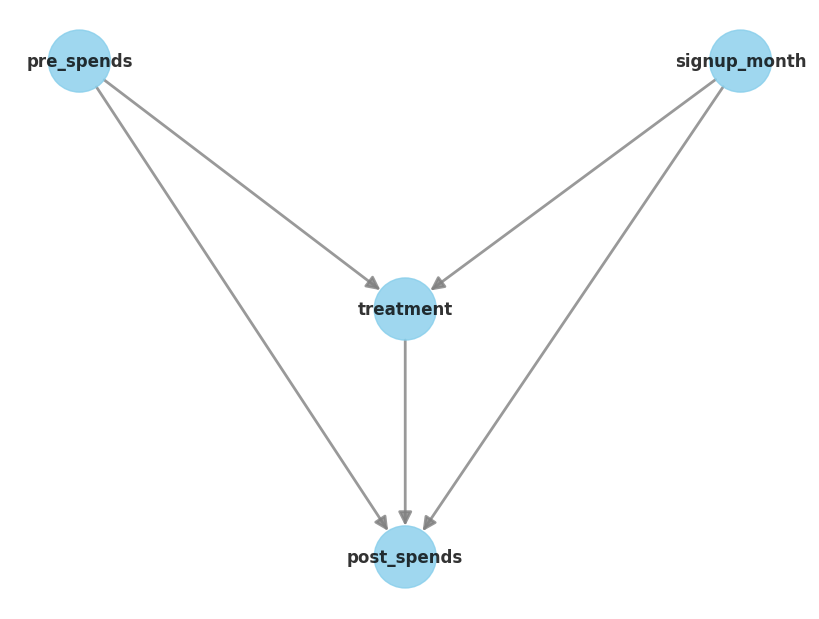

In [ ]:
# model.view_model(layout="dot")
model.view_model(layout="dot")

In [ ]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                              
────────────(E[post_spends|signup_month,pre_spends])
d[treatment]                                        
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→post_spends then P(post_spends|treatment,signup_month,pre_spends,U) = P(post_spends|treatment,signup_month,pre_spends)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

### Estimand : 4
Estimand name: general_adjustment
Estimand expression:
     d                                              
────────────(E[post_spends|signup_month,pre_spends])
d[treatment]                                        
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→post_spends then P(post_spends|treatment,signup_month,pre_spends,U) = P(post_spends|treatment,signup_month,pre_spends)



## Estimate causal effect based on the identified estimand

In [ ]:
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_matching",
    target_units="att",
)

In [ ]:
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                              
────────────(E[post_spends|signup_month,pre_spends])
d[treatment]                                        
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→post_spends then P(post_spends|treatment,signup_month,pre_spends,U) = P(post_spends|treatment,signup_month,pre_spends)

## Realized estimand
b: post_spends~treatment+signup_month+pre_spends
Target units: att

## Estimate
Mean value: 87.82472281198395



### What Conclusion can we draw from the estimated effect?
This says all confounders affecting both treatment and outcome are included in your model.

It assumes there’s no unobserved variable U that affects both treatment and post_spends.

You’re assuming pre_spends and signup_month are enough to "block" all backdoor paths.

| Group               | Average Post-Spends (Roughly) |
| ------------------- | ----------------------------- |
| Treated (Signed Up) | High (e.g., ₹100)             |
| Matched Controls    | Lower (e.g., ₹12.18 less)     |
| Causal Effect (ATT) | **₹87.82** difference         |


```
Mean value: 87.82
```

<b>"We estimate that signing up for the program causes users to spend ₹87.82 more on average, compared to what they would have spent if they hadn’t signed up, even after accounting for the month and their earlier spending."</b>

## Refutation
💡 “How confident can I be that this causal effect is real and not due to some hidden bias or noise?”

In [ ]:
refutation = model.refute_estimate(
    identified_estimand,
    estimate,
    method_name="placebo_treatment_refuter",
    placebo_type="permute",
    num_simulations=20,
)
print(refutation)

Refute: Use a Placebo Treatment
Estimated effect:87.82472281198395
New effect:-0.35714791224345394
p value:0.28540513075337004



The Placebo Test is a method to check the robustness of your causal inference by testing if the effect holds under different conditions or assumptions. It helps to validate whether the observed effect is genuine or if it could be due to confounding factors.

The Test involves creating a "placebo" treatment group that should not have any effect, and then checking if the estimated effect remains significant. If the effect disappears or becomes insignificant in the placebo group, it suggests that the original effect may not be robust.

But in our case the placebo test is not significant, which means the effect we observed is likely genuine and not due to confounding factors.

In our case:
```
placebo_test p_value:0.28540513075337004 
when > 0.05, it means the effect is not significant.
Which means the effect we observed is likely genuine and not due to confounding factors.
```

```
Estimated effect:87.82472281198395
New effect:-0.35714791224345394

Estimated Effect is not affected by the placebo test.
Which States that the effect we observed is likely genuine and not due to confounding factors.
Placebo was not able to find any significant effect.
```

### Conclusion
In this example, we used DoWhy to estimate the causal effect of signing up for a program on user spending. We defined a causal model, identified the estimand, estimated the effect using propensity score matching, and validated our findings through a placebo test.

## Resources:

Kaggle: https://www.kaggle.com/code/adamwurdits/causal-inference-with-dowhy-a-practical-guide<br>
Research Paper: https://arxiv.org/abs/2011.04216<br>
DoWhy Documentation: https://dowhy.readthedocs.io/en/latest/index.html<br>
Youtube: https://www.youtube.com/watch?v=LALfQStONEc&t=1021s<br>


# Backend-style Causal Pipeline (PC + DoWhy)

This section reproduces the backend causal workflow in a notebook-friendly way:
- Pre-clean and prepare data (numeric coercion, drop constants, optional dedupe)
- Learn structure with PC (causal-learn), with safe fallbacks
- Convert to a directed graph for modeling; also produce DOT for visualization
- Run DoWhy: identify, estimate (with estimator fallback), refute (guarded)
- Return a compact result dict similar to the API


In [ ]:
# Setup: install/import libraries and helpers
# Note: skip installs if already present
try:
    import numpy as np
    import pandas as pd
    import networkx as nx
    from causallearn.search.ConstraintBased.PC import pc
    from causallearn.utils.cit import fisherz
    from causallearn.graph.GraphNode import GraphNode
    from causallearn.utils.GraphUtils import GraphUtils
    import dowhy
    from dowhy import CausalModel
except Exception as e:
    import sys, subprocess
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'causal-learn', 'dowhy', 'networkx'])
    import numpy as np
    import pandas as pd
    import networkx as nx
    from causallearn.search.ConstraintBased.PC import pc
    from causallearn.utils.cit import fisherz
    from causallearn.graph.GraphNode import GraphNode
    from causallearn.utils.GraphUtils import GraphUtils
    from dowhy import CausalModel

from typing import Tuple, List, Dict, Any


def coerce_numeric(df: pd.DataFrame) -> pd.DataFrame:
    # convert columns to numeric where possible; keep original for others
    X = df.copy()
    for c in X.columns:
        X[c] = pd.to_numeric(X[c], errors='ignore')
    return X


def drop_constant_cols(df: pd.DataFrame) -> pd.DataFrame:
    nunique = df.nunique(dropna=False)
    keep = nunique[nunique > 1].index.tolist()
    return df[keep].copy()


def select_subset_for_pc(columns: List[str], max_vars: int = 20) -> List[str]:
    if len(columns) <= max_vars:
        return columns
    # take treatment/outcome later; for now simple first-N fallback
    return columns[:max_vars]


def graph_to_edge_sets(cg) -> Tuple[List[Tuple[str,str]], List[Tuple[str,str]]]:
    """
    Returns (directed_edges, skeleton_edges)
    - directed_edges: only oriented edges (u -> v) based on Endpoint marks
    - skeleton_edges: undirected adjacency (u, v) for every learned connection, regardless of orientation
    """
    directed: List[Tuple[str, str]] = []
    skeleton_pairs: set[Tuple[str, str]] = set()

    try:
        edges_iter = list(cg.G.get_edges())  # GeneralGraph API
    except Exception:
        edges_iter = []

    # Import Endpoint inside to avoid import errors if API differs
    try:
        from causallearn.graph.Endpoint import Endpoint
    except Exception:
        Endpoint = None

    for e in edges_iter:
        n1 = str(e.get_node1())
        n2 = str(e.get_node2())
        # Track skeleton as an undirected set (normalize ordering)
        a, b = (n1, n2) if n1 <= n2 else (n2, n1)
        skeleton_pairs.add((a, b))

        # Orientation if available
        if Endpoint is not None:
            try:
                m1 = cg.G.get_endpoint(e.get_node1(), e.get_node2())
                m2 = cg.G.get_endpoint(e.get_node2(), e.get_node1())
                if m1 == Endpoint.TAIL and m2 == Endpoint.ARROW:
                    directed.append((n1, n2))
                elif m2 == Endpoint.TAIL and m1 == Endpoint.ARROW:
                    directed.append((n2, n1))
            except Exception:
                pass

    # Build skeleton edge list (single entry per undirected pair)
    skeleton = [(u, v) for (u, v) in sorted(skeleton_pairs)]
    return directed, skeleton


def pc_learn_structure(df: pd.DataFrame, alpha: float = 0.05) -> Dict[str, Any]:
    cols = df.columns.tolist()
    subset_cols = select_subset_for_pc(cols)
    X = df[subset_cols].to_numpy(dtype=float, copy=True)
    # run PC
    cg = pc(X, alpha=alpha, indep_test_func=fisherz, uc_rule=0, uc_priority=2, stable=True)
    # map back node names
    node_names = subset_cols
    # produce DOT
    dot = GraphUtils.to_pydot(cg.G).to_string()
    # edges: keep both oriented edges and skeleton for visualization
    dir_edges, skel_edges = graph_to_edge_sets(cg)
    learned = {
        'nodes': node_names,
        'edges': [{'source': s, 'target': t} for s, t in skel_edges],
        'edges_directed': [{'source': s, 'target': t} for s, t in dir_edges],
        'dot': dot,
        'algorithm': 'PC',
        'alpha': alpha,
    }
    return learned


def build_nx_digraph(learned: Dict[str, Any]) -> nx.DiGraph:
    G = nx.DiGraph()
    for n in learned['nodes']:
        G.add_node(n)
    for e in learned.get('edges_directed') or []:
        G.add_edge(e['source'], e['target'])
    # ensure all nodes present even if isolated
    return G


def run_dowhy(df: pd.DataFrame, treatment: str, outcome: str, learned: Dict[str, Any]) -> Dict[str, Any]:
    Gnx = build_nx_digraph(learned)
    model = CausalModel(
        data=df,
        treatment=treatment,
        outcome=outcome,
        graph=Gnx
    )
    identificand = model.identify_effect()
    # Try a couple estimators
    estimate = None
    est_value = None
    errors = []
    for method_name in [
        'backdoor.linear_regression',
        'backdoor.propensity_score_matching',
    ]:
        try:
            est = model.estimate_effect(identificand, method_name=method_name)
            estimate = est
            est_value = est.value
            break
        except Exception as ex:
            errors.append(f"{method_name}: {ex}")
            continue
    refutation_txt = None
    try:
        if estimate is not None:
            ref = model.refute_estimate(identificand, estimate, method_name='random_common_cause')
            refutation_txt = str(ref)
    except Exception as ex:
        refutation_txt = f"Refutation skipped/failed: {ex}"
    return {
        'estimand': str(identificand) if identificand is not None else None,
        'estimate_value': float(est_value) if est_value is not None else None,
        'estimate': str(estimate) if estimate is not None else None,
        'refutation': refutation_txt,
        'estimation_errors': errors,
    }

In [20]:
# Load existing CSV and pre-clean
# Adjust the path if your CSV is elsewhere
import os
import pandas as pd

csv_path = os.path.join('..', 'backend', 'tests', 'simulated_data.csv')
print('Reading:', os.path.abspath(csv_path))
raw = pd.read_csv(csv_path)

# Optional: deduplicate
df0 = raw.drop_duplicates().reset_index(drop=True)

# Coerce numeric and drop constants
Xnum = coerce_numeric(df0)
Xnum = drop_constant_cols(Xnum)

# Preview
Xnum.head(), Xnum.shape

Reading: d:\Pro\CSV AI Workflow\backend\tests\simulated_data.csv


(   user_id  signup_month  treatment  pre_spends  post_spends
 0        0             0      False       504.5   422.777778
 1        2             0      False       485.0   434.000000
 2        4             0      False       488.5   420.111111
 3        5             0      False       475.0   408.333333
 4        6             0      False       494.0   423.666667,
 (5473, 5))

In [21]:
# Learn structure with PC
learned = pc_learn_structure(Xnum, alpha=0.05)
print('Nodes:', learned['nodes'])
print('Directed edges:', learned['edges_directed'][:10])
print('DOT snippet:\n', learned['dot'][:300], '...')

Depth=1, working on node 4: 100%|██████████| 5/5 [00:00<00:00, 1000.02it/s]

Nodes: ['user_id', 'signup_month', 'treatment', 'pre_spends', 'post_spends']
Directed edges: []
DOT snippet:
 digraph {
fontsize=18;
dpi=200;
0 [label=X1];
0 [label=X1];
1 [label=X2];
1 [label=X2];
2 [label=X3];
2 [label=X3];
3 [label=X4];
3 [label=X4];
4 [label=X5];
4 [label=X5];
1 -> 2 [dir=both, arrowtail=none, arrowhead=none];
}
 ...


In [ ]:
# Optional: all-pairs effect matrix (commented out for performance)
import numpy as np

def all_pairs_effect_matrix(df: pd.DataFrame,
                            learned: dict,
                            estimators: list | None = None,
                            max_vars: int = 20) -> pd.DataFrame:
    if estimators is None:
        estimators = ['backdoor.linear_regression','backdoor.propensity_score_matching']
    cols = df.columns.tolist()[:max_vars]
    M = pd.DataFrame(np.nan, index=cols, columns=cols)
    for t in cols:
        for y in cols:
            if t == y:
                continue
            try:
                res = run_dowhy(df, treatment=t, outcome=y, learned=learned, estimator_methods=estimators)
                M.loc[t, y] = res['estimate_value']
            except Exception:
                M.loc[t, y] = np.nan
    return M

# To build matrix (can be slow):
# effect_matrix = all_pairs_effect_matrix(Xnum, learned)
# effect_matrix.head()

In [ ]:
# Helper: multi-effect scan (single outcome)
import math, pandas as pd

def multi_effect_scan(df: pd.DataFrame,
                      learned: dict,
                      outcome: str,
                      exclude: list | None = None,
                      estimators: list | None = None,
                      min_unique_treatment: int = 2,
                      max_pairs: int | None = None) -> pd.DataFrame:
    if exclude is None:
        exclude = []
    if estimators is None:
        estimators = [
            'backdoor.linear_regression',
            'backdoor.propensity_score_matching',
        ]
    cols = [c for c in df.columns if c != outcome and c not in exclude]
    rows = []
    for t in cols:
        if df[t].nunique(dropna=True) < min_unique_treatment:
            continue
        res = run_dowhy(df, treatment=t, outcome=outcome, learned=learned, estimator_methods=estimators)
        rows.append({
            'treatment': t,
            'outcome': outcome,
            'used_method': res['used_method'],
            'estimate_value': res['estimate_value'],
            'abs_effect': abs(res['estimate_value']) if res['estimate_value'] is not None else math.nan,
            'refutation': res['refutation'],
            'errors': "; ".join(res['estimation_errors']) if res['estimation_errors'] else ''
        })
        if max_pairs is not None and len(rows) >= max_pairs:
            break
    if not rows:
        return pd.DataFrame(columns=['treatment','outcome','used_method','estimate_value','abs_effect','refutation','errors'])
    out_df = pd.DataFrame(rows).sort_values('abs_effect', ascending=False).reset_index(drop=True)
    return out_df

# Choose an outcome column (fallback to last column if Y absent)
OUTCOME_COL = 'Y' if 'Y' in Xnum.columns else Xnum.columns[-1]

multi_effect_table = multi_effect_scan(Xnum, learned=learned, outcome=OUTCOME_COL)
multi_effect_table.head(15)

## Multi-Effect Explorer
Scan each column as a potential treatment (candidate cause) against a chosen outcome using the learned PC structure.

Workflow:
1. Choose an outcome column present in the cleaned numeric dataframe.
2. For every other column with at least a minimum number of unique values, build a DoWhy model using the oriented subset of edges.
3. Try estimators in priority order (linear regression, then PSM) and record the first successful estimate.
4. Rank rows by absolute effect magnitude.

Notes:
- These effects are not jointly estimated; each is a separate model with its own adjustment set implied by the graph.
- A large absolute value does not guarantee real-world causality; still subject to unmeasured confounding and correct graph orientation.
- Consider running refuters or bootstrapping later for stability.


In [22]:
# Run DoWhy using the learned graph
T_col, Y_col = 'T', 'Y'
results = run_dowhy(Xnum, treatment=T_col, outcome=Y_col, learned=learned)
print('Estimand:\n', results['estimand'])
print('\nEstimate value:', results['estimate_value'])
print('\nEstimate obj:\n', results['estimate'][:500] if results['estimate'] else None)
print('\nRefutation:\n', results['refutation'])
print('\nEstimator errors:', results['estimation_errors'])

NetworkXError: The node T is not in the digraph.

In [23]:
# Compact API-like payload for inspection
payload = {
    'cleaning_performed': True,  # in this demo we deduped and dropped constants
    'original_rows': int(raw.shape[0]),
    'cleaned_rows': int(Xnum.shape[0]),
    'total_rows_removed': int(raw.shape[0] - Xnum.shape[0]),
    'cleaning_summary': 'Dropped constant columns and removed duplicates (if any).',
    'causal': {
        'learned_graph': learned,
        'estimand': results['estimand'],
        'estimate_value': results['estimate_value'],
        'estimate': results['estimate'],
        'refutation': results['refutation'],
    }
}
payload

{'cleaning_performed': True,
 'original_rows': 5473,
 'cleaned_rows': 5473,
 'total_rows_removed': 0,
 'cleaning_summary': 'Dropped constant columns and removed duplicates (if any).',
 'causal': {'learned_graph': {'nodes': ['user_id',
    'signup_month',
    'treatment',
    'pre_spends',
    'post_spends'],
   'edges': [],
   'edges_directed': [],
   'dot': 'digraph {\nfontsize=18;\ndpi=200;\n0 [label=X1];\n0 [label=X1];\n1 [label=X2];\n1 [label=X2];\n2 [label=X3];\n2 [label=X3];\n3 [label=X4];\n3 [label=X4];\n4 [label=X5];\n4 [label=X5];\n1 -> 2 [dir=both, arrowtail=none, arrowhead=none];\n}\n',
   'algorithm': 'PC',
   'alpha': 0.05},
  'estimand': "No directed path from ['T'] to ['Y'] in the causal graph.\nCausal effect is zero.",
  'estimate_value': 0.0,
  'estimate': "*** Causal Estimate ***\n\n## Identified estimand\nNo directed path from ['T'] to ['Y'] in the causal graph.\nCausal effect is zero.\n## Realized estimand\nNone\n## Estimate\nMean value: 0\n",
  'refutation': "Refut

## Generated dataset explained

We simulate a small causal system with 300 rows:
- Z (latent/confounder): unobserved factor driving both treatment and outcome.
- T (treatment): influenced by Z plus random noise.
- Y (outcome): influenced by T and Z plus random noise.
- X1: a noisy proxy of Z (Z + noise) — helps adjust for confounding.
- X2: a noisy proxy of T (T + noise) — often a child of treatment.
- X3: independent binary noise (unrelated to others).
- CONST: constant column (dropped during pre-cleaning).

Intended causal story (true graph):
- Z → T, Z → Y, Z → X1
- T → Y, T → X2
- X3 is independent

Since Z is not measured, the learned structure uses X1 as a proxy and may recover edges like X1 → T and X1 → Y (standing in for Z’s effects). The PC algorithm uses Fisher-Z tests on (approximately) Gaussian variables after numeric coercion and constant drop.

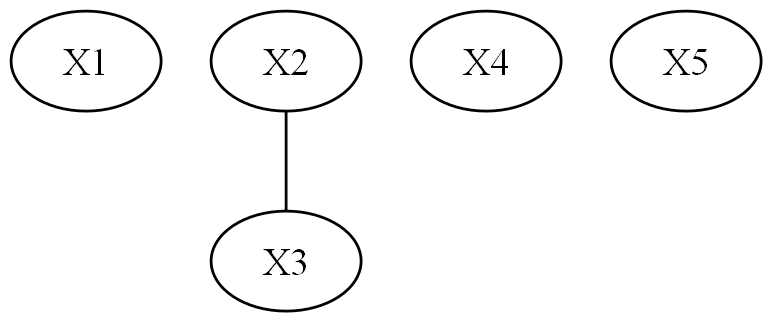

In [24]:
# Visualize the learned graph
# Try pydot graphviz rendering; fallback to networkx spring layout
try:
    import pydot
    from IPython.display import Image, display
    graphs = pydot.graph_from_dot_data(learned['dot'])
    if graphs:
        png = graphs[0].create_png()
        display(Image(png))
    else:
        raise RuntimeError('pydot parsing failed')
except Exception as ex:
    import matplotlib.pyplot as plt
    Gnx_viz = build_nx_digraph(learned)
    plt.figure(figsize=(6,4))
    pos = nx.spring_layout(Gnx_viz, seed=42)
    nx.draw(Gnx_viz, pos, with_labels=True, node_color='#93c5fd', arrows=True, node_size=900)
    plt.title('Learned DAG (fallback)')
    plt.show()
